In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
import geopy.distance

import statsmodels.api as sm


from sklearn.linear_model import LinearRegression
from matplotlib import rcParams
#from scipy.ndimage.filters import gaussian_filter

rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'figure.autolayout': True, 'font.size': 14, })


In [2]:
data = pd.read_csv("data_husky.csv", low_memory=False)
data.drop(data[(data.test==102)|(data.test==10)|(data.test==77)].index, inplace=True)

In [3]:
def gaussian_filter(df, sigma):
    return scipy.ndimage.filters.gaussian_filter(df.power,sigma)

def calculate_distance(df):
    df.reset_index(inplace=True)
    distance = 0
    for i in range(1,len(df)):
        coords_1 = (df.position_y[i-1],df.position_x[i-1])
        coords_2 = (df.position_y[i],df.position_x[i])
        distance += geopy.distance.distance(coords_1, coords_2).km
    return distance  

def calculate_power(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh):
    drag = 0.5*rho*Cd*A*(v**3)
    friction = Crr*Wt*g*v
    slope = Wt*g*v*Z
    acceleration = 0.5*Wt*v*a
    power = (drag + friction + slope)/nbw + acceleration*(1/nbw - nbw*nbr) + Lh

    return power, drag, friction, slope, acceleration   

In [4]:
rho = 1.2
g = 9.81
Crr = 0.01 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
v = 1
payload = 12 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.35
nbr = 0
Lh = 0

In [5]:
tests = list(set(data.test))
data['power_smooth'] = None
sigma = 15

Energy = []
Route = []
Time = []
Payload = []
Speed = []
Test = []
Distance = []
E_drag = []

for test in tests: 
    print(test, end='\r')
    df = data[data.test==test].copy()
    data.loc[data.test==test, 'power_smooth'] = gaussian_filter(df, sigma).astype(float)
    df = data[data.test==test].copy()
    e = scipy.integrate.simps(df['power_smooth'], x=df["time"], even="avg") / 3600
    r = df.route.min()
    p = df.payload.min()
    t = df.time.max() - df.time.min()
    s = df.speed.min()
    d = calculate_distance(df)
    e_drag = []

    # print(rho, Cd, A, s, Crr, Wt, g, Z, nbw, nbr, a, Lh)
    for i in df.index:
        power, drag, friction, slope, acceleration = calculate_power(rho, Cd, A, df.V[i], Crr, Wt, g, Z, nbw, nbr, a, Lh)
        e_drag.append(drag*t/3600)

    E_drag.append(scipy.integrate.simps(e_drag, x=df["time"], even="avg") / 3600)
    Test.append(test)
    Route.append(r)
    Energy.append(e)
    Time.append(t)
    Payload.append(p)
    Speed.append(s)
    Distance.append(d)
 
    
summary_energy = pd.DataFrame({"test":Test, "payload":Payload, "speed":Speed, "route":Route,"energy":Energy, "duration":Time, "distance":Distance, "e_drag":E_drag})

In [6]:
#summary_energy[summary_energy.route=='B']

In [7]:
routes = ['A', 'B', 'C', 'D']
for route in routes:
    t = summary_energy.loc[summary_energy.route==route, 'duration'].mean()
    d = summary_energy.loc[summary_energy.route==route, 'distance'].mean()
    e = summary_energy.loc[summary_energy.route==route, 'energy'].mean()
    

<AxesSubplot:xlabel='route', ylabel='duration'>

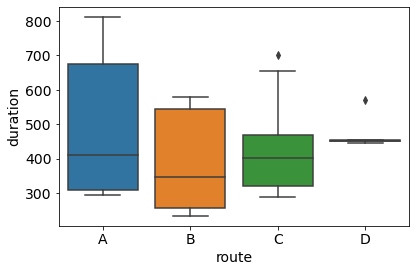

In [8]:
sns.boxplot(x='route', y='duration', data=summary_energy)

In [9]:
summary_energy['drag_ratio'] = 1 - (-summary_energy.e_drag+summary_energy.energy)/summary_energy.energy
print(summary_energy.drag_ratio.mean(),summary_energy.drag_ratio.std())

4.563330630213229e-05 2.5445627263367442e-05


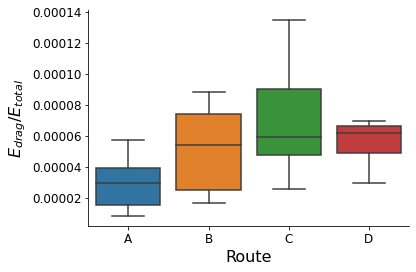

In [10]:
sns.boxplot(x='route', y='drag_ratio', data=summary_energy)
sns.despine(top=True, right=True)
plt.ylabel('$E_{drag}/E_{total}$ ', fontsize=16)
plt.xlabel("Route", fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.savefig("drag_routes.tiff")

(array([0, 1, 2, 3]),
 [Text(0, 0, 'A'), Text(1, 0, 'B'), Text(2, 0, 'C'), Text(3, 0, 'D')])

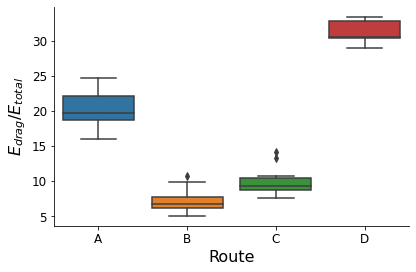

In [11]:
sns.boxplot(x='route', y='energy', data=summary_energy)
sns.despine(top=True, right=True)
plt.ylabel('$E_{drag}/E_{total}$ ', fontsize=16)
plt.xlabel("Route", fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

C:\Users\thiag\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(array([-5.0e-05,  0.0e+00,  5.0e-05,  1.0e-04,  1.5e-04,  2.0e-04]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

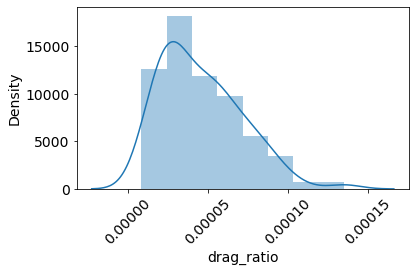

In [12]:
sns.distplot(summary_energy.drag_ratio)

plt.xticks(rotation=45)

In [13]:
summary_energy[np.fabs(summary_energy.drag_ratio) > 0.005]

,test,payload,speed,route,energy,duration,distance,e_drag,drag_ratio


In [14]:

summary_energy

,test,payload,speed,route,energy,duration,distance,e_drag,drag_ratio
0,1,12,1.0,A,20.542184,303.50,0.258148,0.000812,0.000040
1,2,0,0.7,A,17.111553,417.00,0.250925,0.000567,0.000033
2,3,0,1.0,A,17.196350,300.91,0.243670,0.000705,0.000041
3,4,8,1.0,A,19.724464,349.00,0.252590,0.000933,0.000047
4,5,4,0.7,A,19.609177,409.60,0.253348,0.000584,0.000030
...,...,...,...,...,...,...,...,...,...
85,109,0,1.0,D,30.584619,569.21,0.444738,0.000902,0.000029
86,110,0,1.0,D,28.922903,445.00,0.379809,0.002011,0.000070
87,111,0,1.0,D,30.327624,450.30,0.383282,0.002019,0.000067
88,112,0,1.0,D,32.787817,451.70,0.382739,0.001600,0.000049


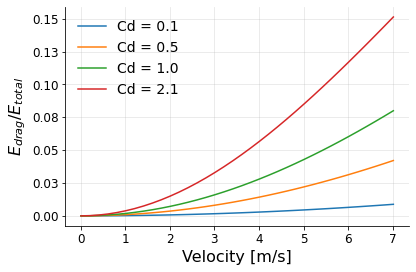

In [15]:
rho = 1.2
g = 9.81
Crr = 0.02 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 

payload = 10 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.8
nbr = 0
Lh = 0
t = 600

from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

Cds = [0.1, 0.5, 1.0 , 2.1]
for Cd in Cds:
    Power = []
    Drag = []
    V = np.arange(0.01,7.2,0.2)
    for v in V:
        power, drag, friction, slope, acceleration = calculate_power(rho, Cd, A, v, Crr, Wt, g, Z, nbw, nbr, a, Lh)
        Power.append(power)
        Drag.append(drag)

    E_total = np.array(Power)*t
    E_Drag = np.array(Drag)*t
    drag_ratio = 1 - (E_total-E_Drag)/(E_total) 
    plt.plot(V, drag_ratio, label ='Cd = %.1f'%Cd)
sns.despine(top=True, right=True)
plt.legend(frameon=False)
plt.xlabel("Velocity [m/s]", fontsize=16)
plt.ylabel('$E_{drag}/E_{total}$ ', fontsize=16)
plt.yticks(fontsize=12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(fontsize=12)
plt.grid(which="major", alpha=0.3)
plt.savefig("drag_speed.tiff")

In [16]:
24/35


0.6857142857142857

In [17]:
W_husky = 50
g = 9.81
data['Wt'] = W_husky + data.payload
data['Z_flipped'] = -data.Z
data['power_smooth'] = data['power_smooth'].astype(float)

data['x1'] = data.Wt*g*data.V
data['x2'] = data.Wt*g*data.V*data.Z_flipped+0.5*data.Wt*data.a

route = 'B'
df = data[data.route==route]
print(len(set(df.test)), len(df))

X = np.array(df[['x1','x2']])
Y = np.array(df['power_smooth'])

#X = sm.add_constant(X)

mod = sm.OLS(Y, X)
res = mod.fit()
df['y_pred'] = res.predict(X)
df['residual'] = df.power_smooth - df.y_pred
print(res.summary())
#c3, c1, c2 = res.params
c1, c2 = res.params

#print(c1,c2, c3)
print(c1,c2)


nbw = 1/c2
Crr = c1*nbw

print("\nRoute: %s \nCrr: %.2f \nnbw: %.2f"%(route, Crr, nbw))
husky_param = pd.DataFrame({"W_husky":W_husky,"g":g,"Crr":Crr, "nbw":nbw},index=[0] )
husky_param.to_csv("Husky_parameters.csv", index=False)

35 132197
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.698
Model:                            OLS   Adj. R-squared (uncentered):              0.698
Method:                 Least Squares   F-statistic:                          1.528e+05
Date:                Sat, 26 Nov 2022   Prob (F-statistic):                        0.00
Time:                        10:54:27   Log-Likelihood:                     -6.9613e+05
No. Observations:              132197   AIC:                                  1.392e+06
Df Residuals:                  132195   BIC:                                  1.392e+06
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/3036099847.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_pred'] = res.predict(X)
C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/3036099847.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residual'] = df.power_smooth - df.y_pred


In [18]:
from sklearn.model_selection import train_test_split





W_husky = 50
g = 9.81
data['Wt'] = W_husky + data.payload
data['Z_flipped'] = -data.Z
data['power_smooth'] = data['power_smooth'].astype(float)

data['x1'] = data.Wt*g*data.V
data['x2'] = data.Wt*g*data.V*data.Z_flipped+0.5*data.Wt*data.a

route = 'B'
df = data[data.route==route]
train, test = train_test_split(df, test_size=0.2)
np.random.seed(25) # random seed to keep results constant 
tests_train = np.random.choice(list(set(df.test)), size=int(0.7*len(set(train.test))), replace=False)
train_set = df[df.test.isin(tests_train)].copy()
test_set = df[~df.test.isin(tests_train)].copy()

# train, test = train_test_split(df, test_size=0.3)
print(len(set(train_set.test)), len(train_set))

X = np.array(train_set[['x1','x2']])
Y = np.array(train_set['power_smooth'])
X_test = np.array(test_set[['x1','x2']])
Y_test = np.array(test_set['power_smooth'])

#X = sm.add_constant(X)

mod = sm.OLS(Y, X)
res = mod.fit()
train_set['y_pred'] = res.predict(X)
train_set['residual'] = train_set.power_smooth - train_set.y_pred

test_set['y_pred'] = res.predict(X_test)
test_set['residual'] = test_set.power_smooth - test_set.y_pred


print(res.summary())
#c3, c1, c2 = res.params
c1, c2 = res.params

#print(c1,c2, c3)
print(c1,c2)


nbw = 1/c2
Crr = c1*nbw

print("\nRoute: %s \nCrr: %f \nnbw: %f"%(route, Crr, nbw))
husky_param = pd.DataFrame({"W_husky":W_husky,"g":g,"Crr":Crr, "nbw":nbw},index=[0] )

husky_param.to_csv("Husky_parameters.csv", index=False)

24 88093
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.702
Model:                            OLS   Adj. R-squared (uncentered):              0.702
Method:                 Least Squares   F-statistic:                          1.038e+05
Date:                Sat, 26 Nov 2022   Prob (F-statistic):                        0.00
Time:                        10:54:27   Log-Likelihood:                     -4.6605e+05
No. Observations:               88093   AIC:                                  9.321e+05
Df Residuals:                   88091   BIC:                                  9.321e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [19]:
import statsmodels.stats.outliers_influence
VIF = statsmodels.stats.outliers_influence.variance_inflation_factor(X,1)

In [20]:
VIF

1.6946979967423608

In [21]:
tests_test = list(set(test_set.test))
ARE = []
e_real = []
e_pred = []

for test in tests_test:
    df = test_set[test_set.test==test].copy()
    e_real.append(scipy.integrate.simps(y=df.power_smooth, x=df["time"], even="avg") / 3600)
    e_pred.append(scipy.integrate.simps(y=df.y_pred, x=df["time"], even="avg") / 3600)
    
ARE =np.fabs(np.array(e_real) - np.array(e_pred))/np.array(e_real)
f = pd.DataFrame({"e_real":e_real, "e_pred":e_pred, "ARE":ARE})
f.ARE.mean(), f.ARE.std()

(0.05367062084484287, 0.028360511112843254)

{'whiskers': [<matplotlib.lines.Line2D at 0x209af2d9310>,
 'caps': [<matplotlib.lines.Line2D at 0x209af2d9a30>,
 'boxes': [<matplotlib.lines.Line2D at 0x209b15ccf40>],
 'medians': [<matplotlib.lines.Line2D at 0x209af2e4190>],
 'fliers': [<matplotlib.lines.Line2D at 0x209af2e4550>],
 'means': []}

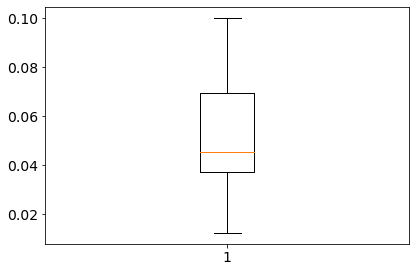

In [22]:
plt.boxplot(f.ARE)

In [23]:
import pylab as py
plt.scatter(test.y_pred, test.power_smooth - test.y_pred, alpha=0.5)
plt.ylabel("P - $\hat{P}$", fontsize=16)
plt.xlabel("$\hat{P}$", fontsize=16)
plt.show()

residuals = (test.residual - test.residual.mean())/test.residual.std() 


sm.qqplot(residuals, line ='45')

py.show()

AttributeError: 'int' object has no attribute 'y_pred'

In [24]:
plt.scatter(test.y_pred, test.power_smooth, alpha = 0.5)
plt.show()


AttributeError: 'int' object has no attribute 'y_pred'

In [25]:
def power_model(Crr, Wt, g, v, nbw, Z, a):
    return (Crr*Wt*g*v + Wt*g*v*Z+0.5*Wt*v*a)/nbw

Husky
144.38666666666668 78.98666666666666

Starship
79.41266666666667 43.442666666666675

Scout
132.35444444444448 72.40444444444447


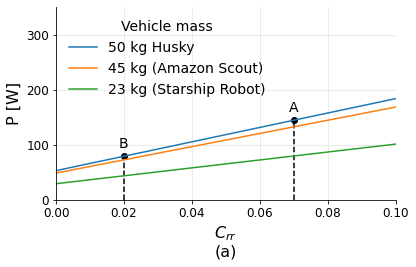

In [26]:
rho = 1.2
g = 9.81
Crr = 0.07 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 

payload = 10 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.45
nbr = 0
Lh = 0

from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()


Wts = [50 + payload, 45 + payload, 23 + payload] 
vehicle = ["50 kg Husky", '45 kg (Amazon Scout)', '23 kg (Starship Robot)']
Crrs = [0.0, 0.1]
v = 1

for i in range(len(Wts)): 
    P_hat = []
    for Crr in Crrs: 
        p_hat = power_model(Crr, Wts[i], g, v, nbw, Z, a)
        P_hat.append(p_hat)  
    plt.plot(Crrs, P_hat, label="%s"%(vehicle[i]))
    
plt.scatter(0.07, power_model(0.07, 60, g, 1, 0.45, Z, a), color="black", marker='o')
plt.vlines(0.07,ymin=0,ymax=power_model(0.07, 60, g, 1, 0.45, Z, a), linestyle='--', color='black')
plt.text(0.07-0.0015, power_model(0.07, 60, g, 1, 0.45, Z, a)+15, 'A')

plt.scatter(0.02, power_model(0.02, 60, g, 1, 0.45, Z, a), color="black", marker='o')
plt.vlines(0.02,ymin=0,ymax=power_model(0.02, 60, g, 1, 0.45, Z, a), linestyle='--', color='black')
plt.text(0.02-0.0015, power_model(0.02, 60, g, 1, 0.45, Z, a)+15, 'B')

husky_a = point_a = power_model(0.07, 60, g, 1, 0.45, Z, a)
husky_b = point_b = power_model(0.02, 60, g, 1, 0.45, Z, a)
husky_c = power_model((0.02+0.07)/2, 60, g, 1, 0.45, Z, a)
print("Husky")
print(point_a, point_b)

starship_a = point_a = power_model(0.07, 33, g, 1, 0.45, Z, a)
starship_b = point_b = power_model(0.02, 33, g, 1, 0.45, Z, a)
print("\nStarship")
print(point_a, point_b)

scout_a = point_a = power_model(0.07, 55, g, 1, 0.45, Z, a)
scout_b = point_b = power_model(0.02, 55, g, 1, 0.45, Z, a)
print("\nScout")
print(point_a, point_b)


sns.despine(top=True, right=True)
plt.legend(title="Vehicle mass", frameon=False, loc="upper left" )
plt.xlabel("$C_{rr}$\n(a)", fontsize=16)
plt.ylabel('P [W]', fontsize=16)
plt.yticks(fontsize=12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xlim(0,0.1)
plt.ylim(0, 350)
plt.xticks(fontsize=12)
plt.grid(which="major", alpha=0.3)
plt.show()
#plt.savefig("p_hat_Crr.tiff")

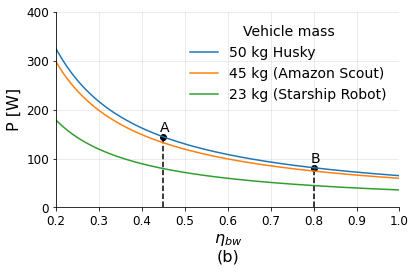

In [28]:
rho = 1.2
g = 9.81
Crr = 0.07 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 

payload = 10 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.9
nbr = 0
Lh = 0
t = 600

from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

V = [1]

Wts = [50 + payload, 45 + payload, 23 + payload] 
vehicle = ["50 kg Husky", '45 kg (Amazon Scout)', '23 kg (Starship Robot)']
Crrs = [0.0, 0.2]
v = 1

nbws = np.arange(0.2,1,0.001)


for i in range(len(Wts)): 
    P_hat = []
    for nbw in nbws: 
        p_hat = power_model(Crr, Wts[i], g, v, nbw, Z, a)
        P_hat.append(p_hat)  
    plt.plot(nbws, P_hat, label="%s"%(vehicle[i]))

plt.scatter(0.45, power_model(Crr, 60, g, 1, 0.45, Z, a), color="black", marker='o')
plt.vlines(0.45,ymin=0,ymax=power_model(Crr, 60, g, 1, 0.45, Z, a), linestyle='--', color='black')
plt.text(0.45-0.008, power_model(Crr, 60, g, 1, 0.45, Z, a)+10, 'A')

plt.scatter(0.8, power_model(Crr, 60, g, 1, 0.8, Z, a), color="black", marker='o')
plt.vlines(0.8,ymin=0,ymax=power_model(Crr, 60, g, 1, 0.8, Z, a), linestyle='--', color='black')
plt.text(0.8-0.008, power_model(Crr, 60, g, 1, 0.8, Z, a)+10, 'B')



sns.despine(top=True, right=True)
plt.legend(title="Vehicle mass", frameon=False)
plt.xlabel("$\eta_{bw}$\n(b)", fontsize=16)
plt.ylabel('P [W]', fontsize=16)
plt.yticks(fontsize=12)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
plt.xticks(fontsize=12)
plt.grid(which="major", alpha=0.3)
plt.xlim(0.2,1)
plt.ylim(0, max(ax.get_yticks()))
plt.savefig("p_hat_nbw.tiff")


In [29]:
tests_B = list(set(data.loc[data.route=='B', 'test'].copy()))

rho = 1.2
g = 9.81
print(Crr, nbw)
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 

payload = 10 # kg

nbr = 0
Lh = 0
t = 600


V = np.arange(0.5,7.5,0.5)
print(V)
distance = []
E = []
for test in tests_B: 
    df = data[data.test==test].copy()
    #print(df.V.mean(), df.speed.mean())
    e = []
    
    
    for i in range(len(V)):
        v_multiplier = V[i]/df.speed.mean()  
        v = v_multiplier*df.V
        a = v_multiplier*df.a
        
        
        df['P_hat'] = (Crr*df.Wt*g*v + df.Wt*g*v*df.Z_flipped+0.5*df.Wt*v*a)/nbw 
        e.append(scipy.integrate.simps(y=df['P_hat'], x=df["time"], even="avg") / 3600)
    E.append(e)
    distance.append(v_multiplier*calculate_distance(df))

E = np.array(E)

df_E = pd.DataFrame()
for i in range(len(V)):
    df_E['v_%.1f'%V[i]] = E[:,i]
df_E['d'] = distance

0.07 0.9990000000000008
[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]


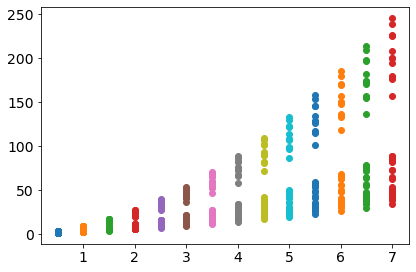

In [30]:
for i in range(len(V)):
    plt.scatter([V[i] for v in range(len(df_E))],df_E['v_%.1f'%V[i]])
plt.show()


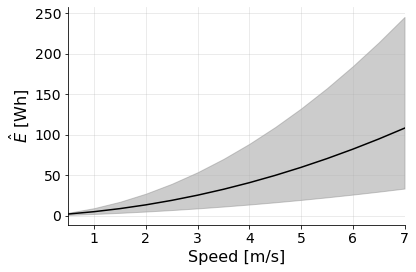

In [31]:
E_hat = []
E_hat_max = []
E_hat_min = []


for i in range(len(V)):
    E_hat.append(df_E['v_%.1f'%V[i]].mean())
    E_hat_max.append(df_E['v_%.1f'%V[i]].max())
    E_hat_min.append(df_E['v_%.1f'%V[i]].min())
     
plt.grid(which="major", alpha=0.3)
plt.plot(V, E_hat, color='black')
plt.fill_between(V, E_hat_max, y2=E_hat_min, where=None, alpha=0.4, color='gray')
sns.despine(top=True, right=True)
plt.xlim(0.5,7)
#plt.ylim(0, 550)
plt.xlabel('Speed [m/s]', fontsize=16)
plt.ylabel("$\hat{E}$ [Wh]", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("E_routing.tiff")
plt.show()

51 0.7988098322802942 1.0


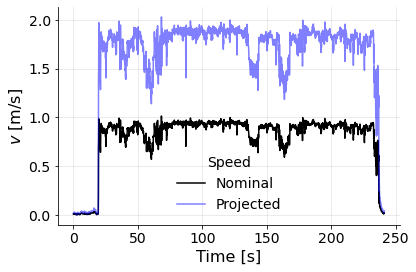

51 0.7988098322802942 1.0


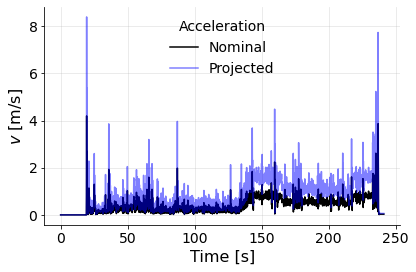

In [32]:
V = [2]

for test in [51]: #[tests_B: 
    df = data[data.test==test].copy()
    print(test, df.V.mean(), df.speed.mean())
    e = []
    plt.grid(which="major", alpha=0.3)
    plt.plot(df.time, df.V, label = "Nominal", color="black")
        
    for i in range(len(V)):
        v_multiplier = V[i]/df.speed.mean()  
        v = v_multiplier*df.V
        a = v_multiplier*df.a
        plt.plot(df.time, v, label = "Projected", alpha=0.5, color="blue")
    plt.legend(title="Speed", frameon=False)
    plt.xlabel("Time [s]", fontsize=16)
    plt.ylabel("$v$ [m/s]", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.despine(top=True)
    plt.savefig("multiplier_V.tiff")
    plt.show()
    
for test in [51]: #[tests_B: 
    df = data[data.test==test].copy()
    print(test, df.V.mean(), df.speed.mean())
    e = []    
    plt.grid(which="major", alpha=0.3)
    plt.plot(df.time, df.a, label = "Nominal",color="black")
        
    for i in range(len(V)):
        v_multiplier = V[i]/df.speed.mean()  
        v = v_multiplier*df.V
        a = v_multiplier*df.a
        plt.plot(df.time, a, label = "Projected", alpha=0.5, color="blue")
    plt.legend(title="Acceleration", frameon=False)
    plt.xlabel("Time [s]", fontsize=16)
    plt.ylabel("$v$ [m/s]", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.despine(top=True)
    plt.savefig("multiplier_a.tiff")

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6.  6.5 7. ]


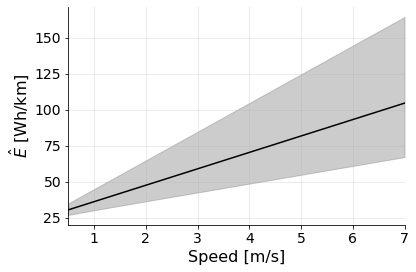

In [33]:
rho = 1.2
g = 9.81
Crr = 0.07336175704606501
nbw = 0.4526712296391247
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 
Wt = 50 + 10

payload = 10 # kg

nbr = 0
Lh = 0
t = 600


V = np.arange(0.5,7.5,0.5)
print(V)
distance = []
P_hat_avg = []
for test in tests_B: 
    df = data[data.test==test].copy()
    #print(df.V.mean(), df.speed.mean())
    p_hat_avg = []
    
    
    for i in range(len(V)):
        v_multiplier = V[i]/df.speed.mean()  
        v = v_multiplier*df.V
        a = v_multiplier*df.a
        df['P_hat'] = (Crr*Wt*g*v + Wt*g*v*df.Z_flipped+0.5*Wt*v*a)/nbw 
        p_hat_avg.append((df.P_hat.mean()/v.mean())/3.6)
    P_hat_avg.append(p_hat_avg)
    
P = np.array(P_hat_avg)

df_P = pd.DataFrame()
for i in range(len(V)):
    df_P['v_%.1f'%V[i]] = P[:,i]
    
P_hat = []
P_hat_max = []
P_hat_min = []


for i in range(len(V)):
    P_hat.append(df_P['v_%.1f'%V[i]].mean())
    P_hat_max.append(df_P['v_%.1f'%V[i]].max())
    P_hat_min.append(df_P['v_%.1f'%V[i]].min())
     
plt.grid(which="major", alpha=0.3)
plt.plot(V, P_hat, color='black')
plt.fill_between(V, P_hat_max, y2=P_hat_min, where=None, alpha=0.4, color='gray')
sns.despine(top=True, right=True)
plt.xlim(0.5,7)
#plt.ylim(0, 550)
plt.xlabel('Speed [m/s]', fontsize=16)
plt.ylabel("$\hat{E}$ [Wh/km]", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("E_routing.tiff")
plt.show()


In [34]:
g = 9.81
Crr = 0.07
nbw = 0.45
Wts = [50, 45, 23]
payload = 10 # kg
Z = 0.02
a = 0.4


v = 1 

eff = 0.88*(1-6.5/100)

e = []
for Wt in Wts:
    e.append(power_model(Crr, Wt + payload, g, v, nbw, Z, a)/(v*3.6))
e = np.array(e)
print("base case, CRR and nbw found in the OLS")
print(e)
print(e/eff)
print(e*0.0036/eff)

e = []
Crr = 0.02
nbw = 0.8

for Wt in Wts:
    e.append(power_model(Crr, Wt + payload, g, v, nbw, Z, a)/(v*3.6))
e = np.array(e)
print("\n\nbest case, CRR = 0.02 and nbw = 0.08")
print(e)
print(e/eff)
print(e*0.0036/eff)

e = []
Crr = 0.1
nbw = 0.3
for Wt in Wts:
    e.append(power_model(Crr, Wt + payload, g, v, nbw, Z, a)/(v*3.6))
e = np.array(e)
print("\n\nwost case, CRR = 0.1 and nbw = 0.03")
print(e)
print(e/eff)
print(e*0.0036/eff)

base case, CRR and nbw found in the OLS
[40.10740741 36.76512346 22.05907407]
[48.74502602 44.68294052 26.80976431]
[0.17548209 0.16085859 0.09651515]


best case, CRR = 0.02 and nbw = 0.08
[12.34166667 11.31319444  6.78791667]
[14.99959488 13.74962864  8.24977718]
[0.05399854 0.04949866 0.0296992 ]


wost case, CRR = 0.1 and nbw = 0.03
[76.51111111 70.13518519 42.08111111]
[92.98871064 85.23965142 51.14379085]
[0.33475936 0.30686275 0.18411765]


In [35]:
tests = list(set(data.loc[data.route=='B', 'test']))
rho = 1.2
g = 9.81
Crr = 0.01 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 

payload = 12 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.9
nbr = 0
Lh = 0
t = 600

In [36]:
for test in tests: 
    print(test, end='\r')
    df = data[data.test==test].copy()
    

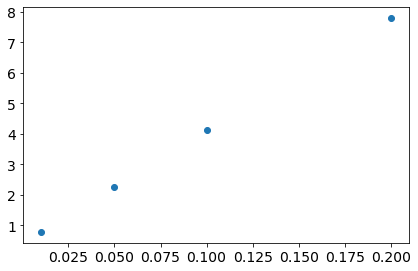

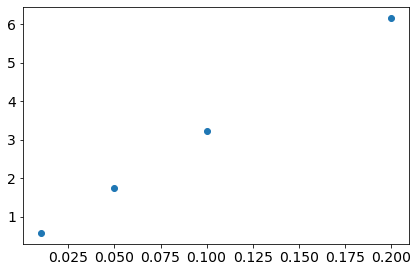

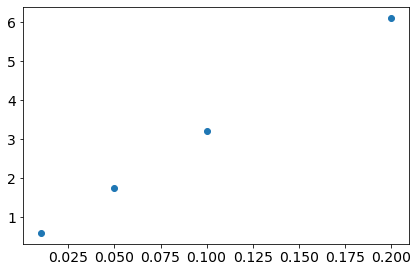

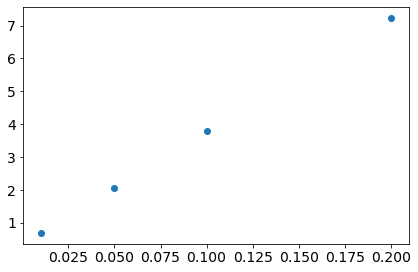

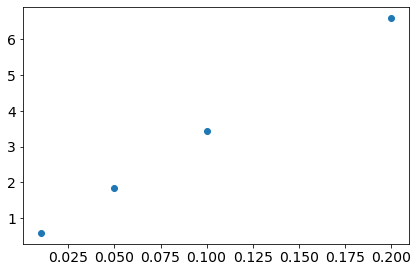

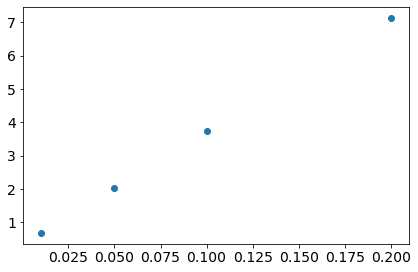

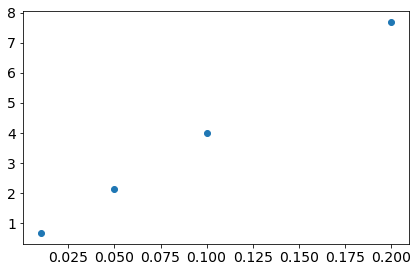

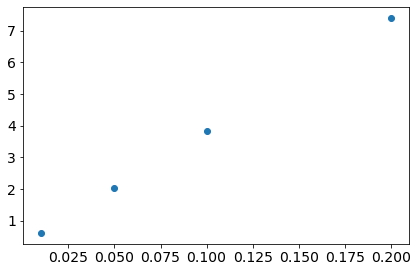

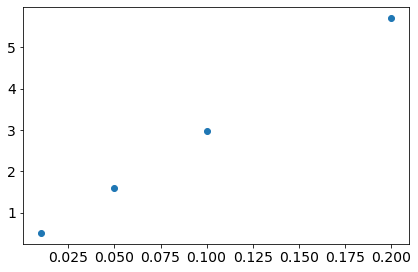

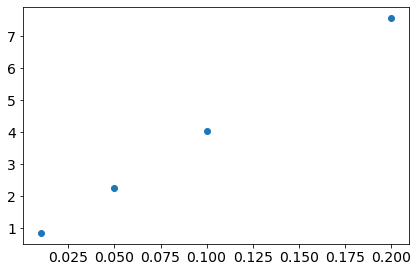

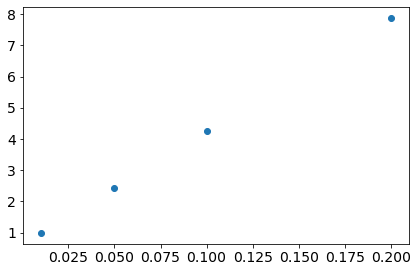

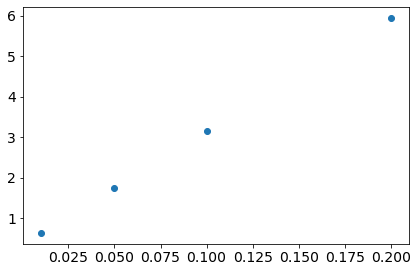

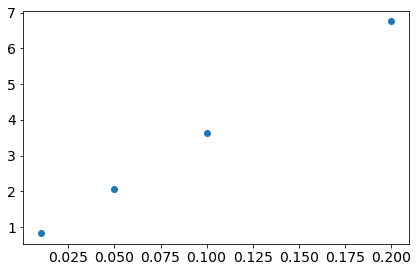

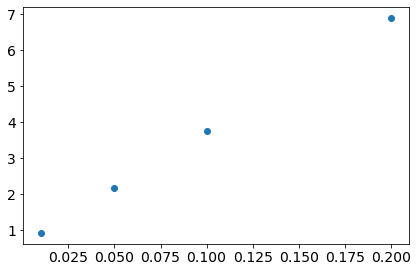

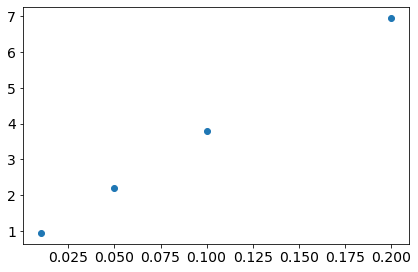

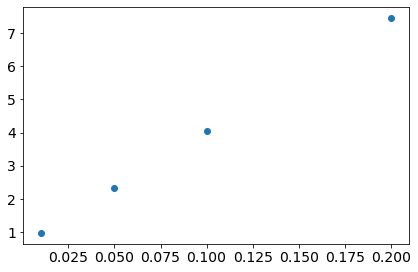

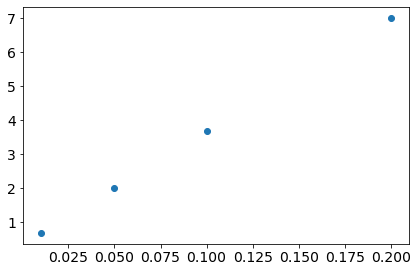

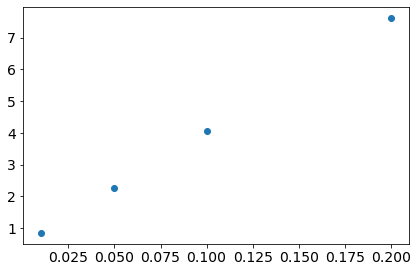

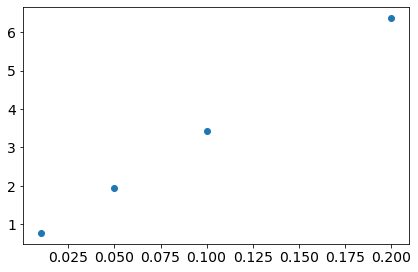

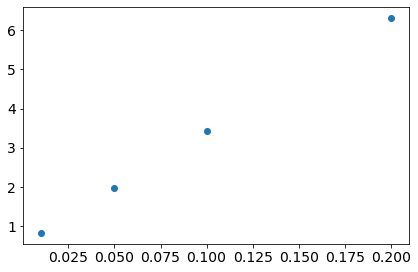

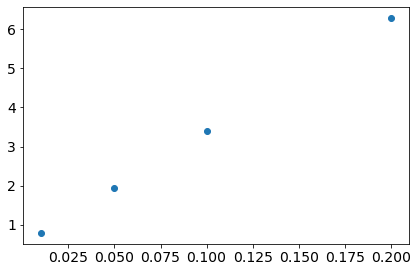

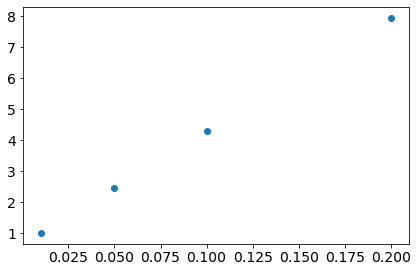

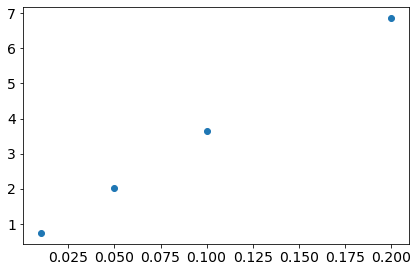

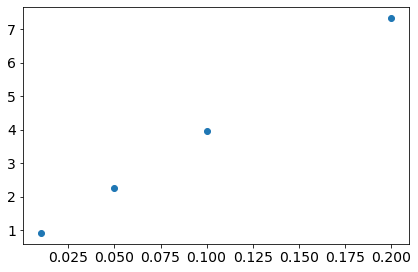

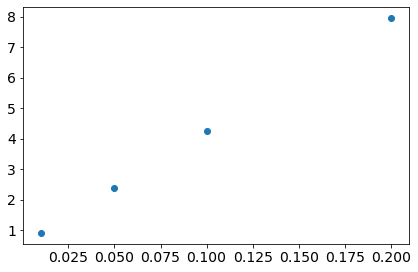

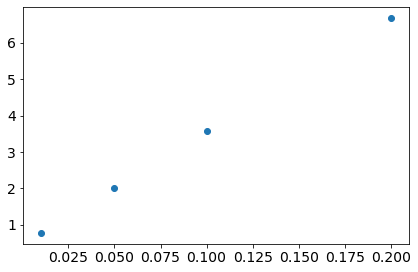

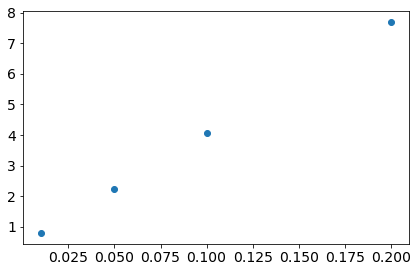

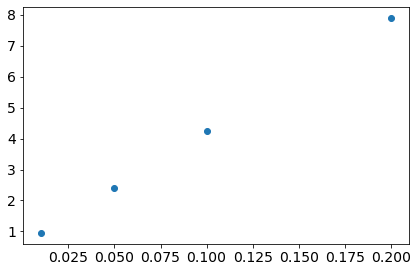

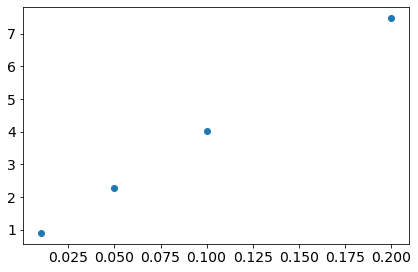

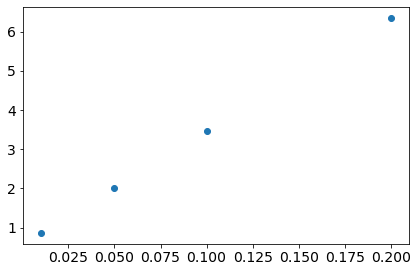

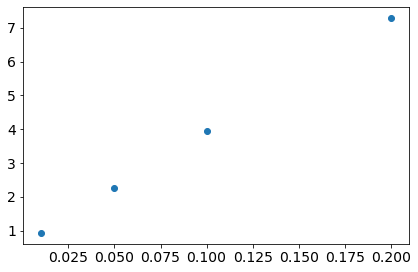

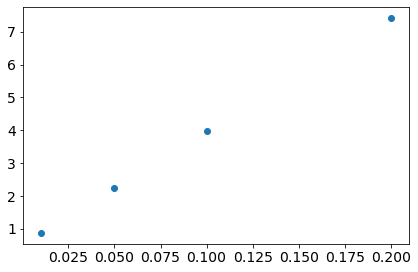

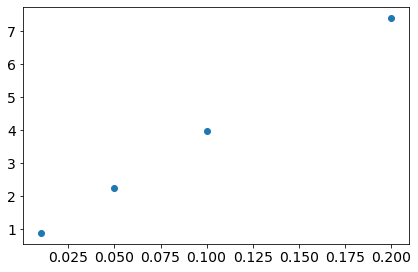

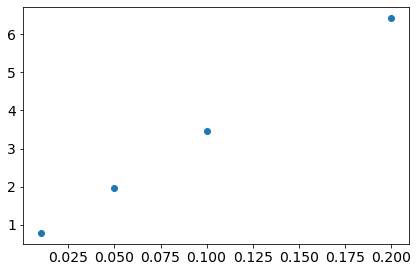

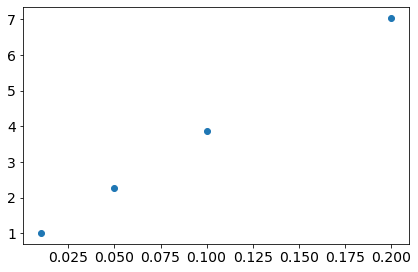

In [37]:
f = pd.DataFrame()

Crrs = [0.01, 0.05, 0.10, 0.20]

for test in tests:
    df = data[data.test==test].copy()
    df.reset_index()
    E = []
    for Crr in Crrs: 
        df['P_hat_Crr_'+str(Crr)] = (Crr*df.Wt*g*df.V + df.Wt*g*df.V*df.Z_flipped+0.5*df.Wt*df.V*df.a)/nbw
        #plt.plot(df.time, df['P_hat_Crr_'+str(Crr)])
        
        E.append(scipy.integrate.simps(y=df['P_hat_Crr_'+str(Crr)], x=df["time"], even="avg") / 3600)
    plt.scatter(Crrs, E)
    f['E_hat_Crr_'+str(Crr)] = E 
    plt.show()
    


In [38]:
f

,E_hat_Crr_0.2
0,1.003380
1,2.274875
2,3.864245
3,7.042983


In [39]:
vc_pack = pd.read_csv("vehicle_package_comparison.csv")
vc = pd.read_csv("vehicle_km_comparison.csv")

In [40]:
vc

,vehicle,e_base,e_low,e_high,ghg_base,ghg_high,ghg_low
0,Medium duty diesel truck,11.000000,8.800000,13.200000,931.590000,1086.140000,780.340000
1,Small diesel vans,4.900000,3.920000,5.880000,414.981000,483.826000,347.606000
2,Medium duty e-truck,3.800000,3.040000,4.560000,782.478685,1249.414925,445.992465
3,Small electric van,1.650000,1.320000,1.980000,343.460927,546.331405,197.240496
4,Electric cargo bicycle,0.100000,0.080000,0.120000,23.445557,33.781770,12.476957
5,Quad-copter drone,0.075000,0.070000,0.080000,17.534114,29.399622,9.499852
6,Amazon Scout,0.199979,0.126468,0.298595,42.967930,65.992503,22.397584
7,Starship Robot,0.144699,0.087223,0.214807,30.782645,47.529037,16.173017


In [41]:
vc

,vehicle,e_base,e_low,e_high,ghg_base,ghg_high,ghg_low
0,Medium duty diesel truck,11.000000,8.800000,13.200000,931.590000,1086.140000,780.340000
1,Small diesel vans,4.900000,3.920000,5.880000,414.981000,483.826000,347.606000
2,Medium duty e-truck,3.800000,3.040000,4.560000,782.478685,1249.414925,445.992465
3,Small electric van,1.650000,1.320000,1.980000,343.460927,546.331405,197.240496
4,Electric cargo bicycle,0.100000,0.080000,0.120000,23.445557,33.781770,12.476957
5,Quad-copter drone,0.075000,0.070000,0.080000,17.534114,29.399622,9.499852
6,Amazon Scout,0.199979,0.126468,0.298595,42.967930,65.992503,22.397584
7,Starship Robot,0.144699,0.087223,0.214807,30.782645,47.529037,16.173017


In [42]:
sub = vc.loc[4:,:].copy()

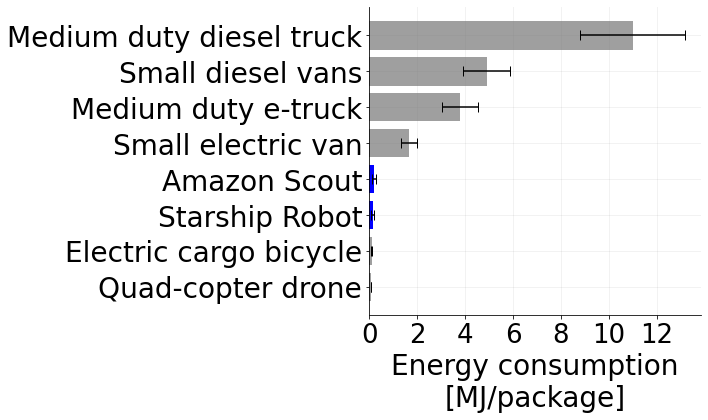

In [43]:

plt.rcParams.update({'figure.autolayout': True, 'font.size': 12, })


df = vc.copy()
df = df.sort_values(by=['e_base'])

color_others = "#9F9F9F"
plt.figure(figsize=(10, 6))
plt.barh(df['vehicle'], df.e_base,
         color=[color_others, color_others,   "blue", "blue",color_others,color_others,  color_others, color_others,color_others],
         xerr=np.array([df.e_base-df.e_low, df.e_high-df.e_base]), capsize=5)

plt.xticks(fontsize=26)
plt.yticks(fontsize=28)
sns.despine(top=True, right=True)
plt.grid(which='major', axis='both', color='gray', linewidth=1.0, alpha=0.1)
plt.xlabel('Energy consumption\n[MJ/package]', fontsize=28)
plt.savefig("energy_km.tiff")
plt.show()

C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/541305537.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=5)


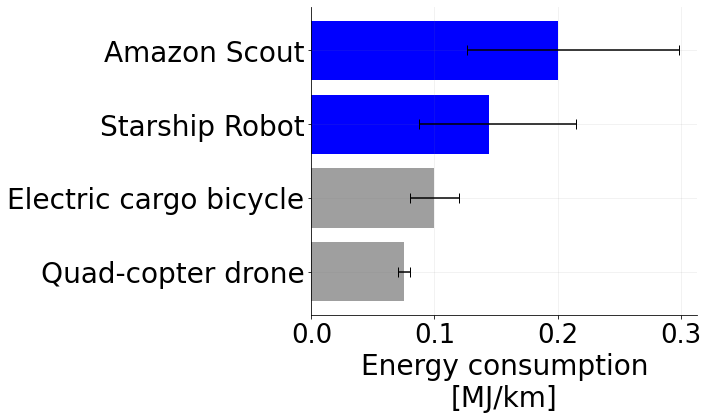

In [44]:
df = sub.copy()
df = df.sort_values(by=['e_base'])

color_others = "#9F9F9F"
plt.figure(figsize=(10, 6))
plt.barh(df['vehicle'], df.e_base,
         color=[color_others, color_others,   "blue", "blue",color_others,color_others,  color_others, color_others,color_others],
         xerr=np.array([df.e_base-df.e_low, df.e_high-df.e_base]), capsize=5)

plt.locator_params(nbins=5)
plt.xticks(fontsize=26)
plt.yticks(fontsize=28)
sns.despine(top=True, right=True)
plt.grid(which='major', axis='both', color='gray', linewidth=1.0, alpha=0.1)
plt.xlabel('Energy consumption\n[MJ/km]', fontsize=28)
plt.savefig("energy_sub_km.tiff")
plt.show()

C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/1626177831.py:10: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=5)


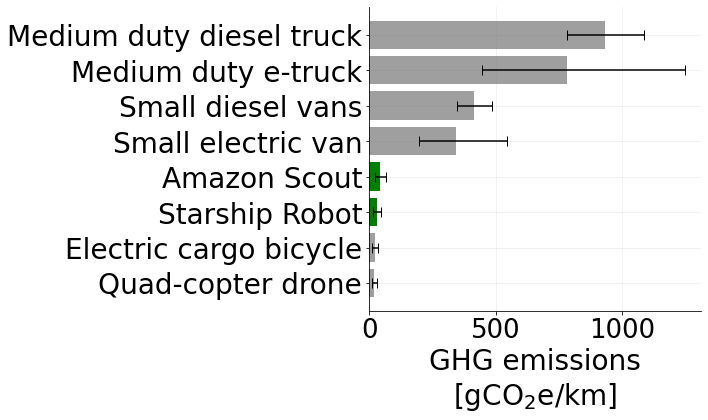

In [45]:
df = vc.copy()
df = df.sort_values(by=['ghg_base'])

color_others = "#9F9F9F"
plt.figure(figsize=(10, 6))
plt.barh(df['vehicle'], df.ghg_base,
         color=[color_others, color_others,   "green", "green",color_others,color_others,  color_others, color_others,color_others],
         xerr=np.array([df.ghg_base-df.ghg_low, df.ghg_high-df.ghg_base]), capsize=5)

plt.locator_params(nbins=5)
plt.xticks(fontsize=26)
plt.yticks(fontsize=28)
sns.despine(top=True, right=True)
plt.grid(which='major', axis='both', color='gray', linewidth=1.0, alpha=0.1)
plt.xlabel('GHG emissions\n[gCO$_{2}$e/km]', fontsize=28)
plt.savefig("ghg_km.tiff")
plt.show()

C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/632435629.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=5)


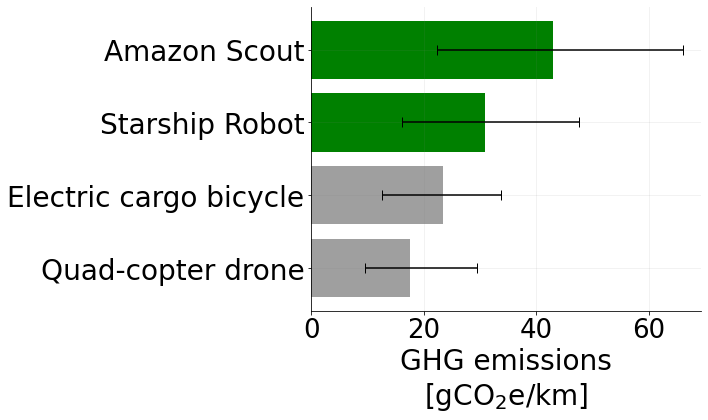

In [46]:
df = sub.copy()
df = df.sort_values(by=['ghg_base'])

color_others = "#9F9F9F"
plt.figure(figsize=(10, 6))
plt.barh(df['vehicle'], df.ghg_base,
         color=[color_others, color_others,   "green", "green",color_others,color_others,  color_others, color_others,color_others],
         xerr=np.array([df.ghg_base-df.ghg_low, df.ghg_high-df.ghg_base]), capsize=5)
plt.locator_params(nbins=5)
plt.xticks(fontsize=26)
plt.yticks(fontsize=28)
sns.despine(top=True, right=True)
plt.grid(which='major', axis='both', color='gray', linewidth=1.0, alpha=0.1)
plt.xlabel('GHG emissions\n[gCO$_{2}$e/km]', fontsize=28)
plt.savefig("ghg_sub_km.tiff")
plt.show()

In [47]:
vc

,vehicle,e_base,e_low,e_high,ghg_base,ghg_high,ghg_low
0,Medium duty diesel truck,11.000000,8.800000,13.200000,931.590000,1086.140000,780.340000
1,Small diesel vans,4.900000,3.920000,5.880000,414.981000,483.826000,347.606000
2,Medium duty e-truck,3.800000,3.040000,4.560000,782.478685,1249.414925,445.992465
3,Small electric van,1.650000,1.320000,1.980000,343.460927,546.331405,197.240496
4,Electric cargo bicycle,0.100000,0.080000,0.120000,23.445557,33.781770,12.476957
5,Quad-copter drone,0.075000,0.070000,0.080000,17.534114,29.399622,9.499852
6,Amazon Scout,0.199979,0.126468,0.298595,42.967930,65.992503,22.397584
7,Starship Robot,0.144699,0.087223,0.214807,30.782645,47.529037,16.173017


In [48]:
0.08/5.4

0.014814814814814814

0.5 0.252936316 0.597190082


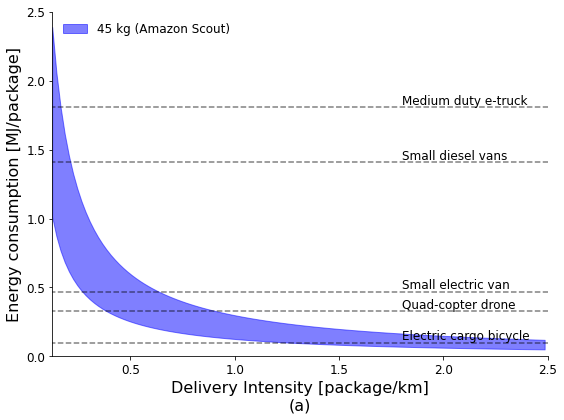

In [49]:
pack_km = np.arange(1/8, 1/0.4 , 0.02)

e_pack = []
e_pack_high = []
e_pack_low = []

plt.figure(figsize=(8, 6))
for i in pack_km:
    e_pack.append(vc.loc[6,'e_base']/i)
    e_pack_high.append(vc.loc[6,'e_high']/i)
    e_pack_low.append(vc.loc[6,'e_low']/i)

i = 0.5
print(i, vc.loc[6,'e_low']/i, vc.loc[6,'e_high']/i)


plt.fill_between(pack_km, y1=e_pack_high, y2=e_pack_low, alpha=0.5, color='blue', label='45 kg (Amazon Scout)')
#plt.plot(pack_km, e_pack, color='black')
for i in range(1,6):
    plt.hlines(vc_pack.loc[i,'e_base'], xmin=0, xmax=1/0.4,linestyle='--', color='black', alpha=0.5)
    #plt.fill_between(pack_km, y1=vc_pack.loc[i,'e_low'],y2= vc_pack.loc[i,'e_high'], alpha=0.5)
    plt.text(1.8, vc_pack.loc[i,'e_base']+0.02, vc_pack.loc[i,'vehicle'])


plt.xlim(1/8,1/0.4)
plt.ylim(0,2.5)
plt.xlabel("Delivery Intensity [package/km]\n(a)", fontsize=16)
plt.ylabel("Energy consumption [MJ/package]", fontsize=16)
sns.despine(top=True, right=True)
plt.legend(frameon=False, loc="upper left")
plt.savefig("delivey_intensity_scout.tiff")
plt.show()


0.5 0.174445794 0.429613514


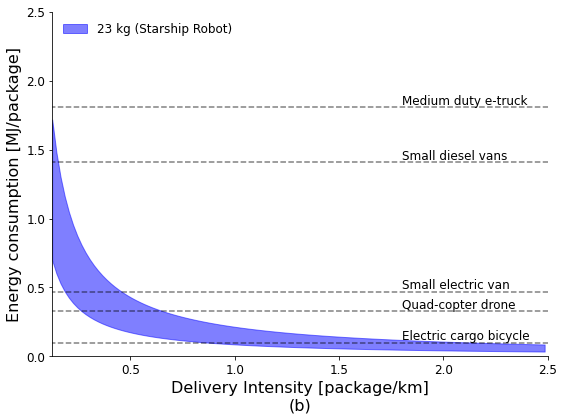

In [50]:
pack_km = np.arange(1/8, 1/0.4 , 0.02)

e_pack = []
e_pack_high = []
e_pack_low = []

plt.figure(figsize=(8, 6))
for i in pack_km:
    e_pack.append(vc.loc[7,'e_base']/i)
    e_pack_high.append(vc.loc[7,'e_high']/i)
    e_pack_low.append(vc.loc[7,'e_low']/i)

i = 0.5
print(i, vc.loc[7,'e_low']/i, vc.loc[7,'e_high']/i)

plt.fill_between(pack_km, y1=e_pack_high, y2=e_pack_low, alpha=0.5, color='blue', label='23 kg (Starship Robot)')
#plt.plot(pack_km, e_pack, color='black')
for i in range(1,6):
    plt.hlines(vc_pack.loc[i,'e_base'], xmin=0, xmax=1/0.4,linestyle='--', color='black', alpha=0.5)
    plt.text(1.8, vc_pack.loc[i,'e_base']+0.02, vc_pack.loc[i,'vehicle'])
plt.xlim(1/8,1/0.4)
plt.ylim(0,2.5)
plt.xlabel("Delivery Intensity [package/km]\n(b)", fontsize=16)
plt.ylabel("Energy consumption [MJ/package]", fontsize=16)
sns.despine(top=True, right=True)
plt.legend(frameon=False, loc="upper left")
plt.savefig("delivey_intensity_starship.tiff")
plt.show()

0.5 32.34603492 95.05807428


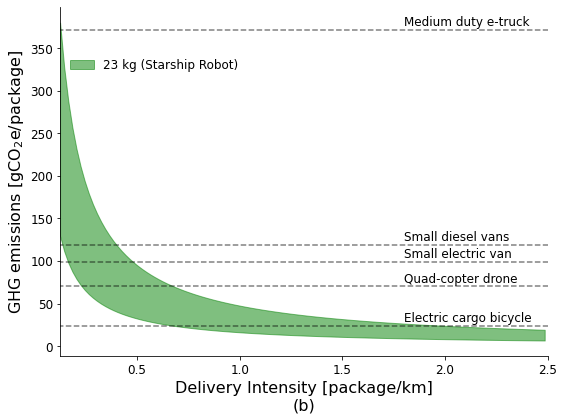

In [51]:
pack_km = np.arange(1/8, 1/0.4 , 0.02)

e_pack = []
e_pack_high = []
e_pack_low = []

plt.figure(figsize=(8, 6))
for i in pack_km:
    e_pack.append(vc.loc[7,'ghg_base']/i)
    e_pack_high.append(vc.loc[7,'ghg_high']/i)
    e_pack_low.append(vc.loc[7,'ghg_low']/i)

i = 0.5
print(i, vc.loc[7,'ghg_low']/i, vc.loc[7,'ghg_high']/i)



plt.fill_between(pack_km, y1=e_pack_high, y2=e_pack_low, alpha=0.5, color='green', label='23 kg (Starship Robot)')
#plt.plot(pack_km, e_pack, color='black')
for i in range(1,6):
    plt.hlines(vc_pack.loc[i,'ghg_base'], xmin=0, xmax=1/0.4,linestyle='--', color='black', alpha=0.5)
    plt.text(1.8, vc_pack.loc[i,'ghg_base']+5, vc_pack.loc[i,'vehicle'])
    
plt.xlim(1/8,1/0.4)
#plt.ylim(0,2.5)
plt.xlabel("Delivery Intensity [package/km]\n(b)", fontsize=16)
plt.ylabel("GHG emissions [gCO$_{2}$e/package]", fontsize=16)
sns.despine(top=True, right=True)
plt.legend(frameon=False, loc=(0.01,0.8))
plt.savefig("ghg_delivey_intensity_starship.tiff")
plt.show()

0.5 44.79516818 131.9850055


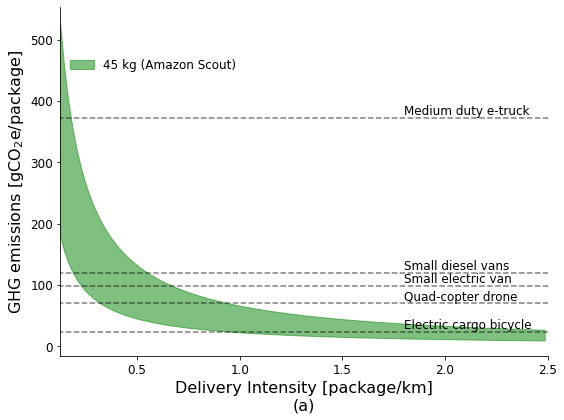

In [52]:
pack_km = np.arange(1/8, 1/0.4 , 0.02)

e_pack = []
e_pack_high = []
e_pack_low = []


plt.figure(figsize=(8, 6))
for i in pack_km:
    e_pack.append(vc.loc[6,'ghg_base']/i)
    e_pack_high.append(vc.loc[6,'ghg_high']/i)
    e_pack_low.append(vc.loc[6,'ghg_low']/i)

i = 0.5
print(i, vc.loc[6,'ghg_low']/i, vc.loc[6,'ghg_high']/i)



plt.fill_between(pack_km, y1=e_pack_high, y2=e_pack_low, alpha=0.5, color='green', label='45 kg (Amazon Scout)')

#plt.plot(pack_km, e_pack, color='black')
for i in range(1,6):
    plt.hlines(vc_pack.loc[i,'ghg_base'], xmin=0, xmax=1/0.4,linestyle='--', color='black', alpha=0.5)
    plt.text(1.8, vc_pack.loc[i,'ghg_base']+5, vc_pack.loc[i,'vehicle'])


plt.xlim(1/8,1/0.4)
#plt.ylim(0,2.5)
plt.xlabel("Delivery Intensity [package/km]\n(a)", fontsize=16)
plt.ylabel("GHG emissions [gCO$_{2}$e/package]", fontsize=16)
sns.despine(top=True, right=True)
plt.legend(frameon=False, loc=(0.01,0.8))
plt.savefig("ghg_delivey_intensity_Amazon.tiff")
plt.show()

In [53]:

3939+9*250

6189

In [54]:
B = data[data.route=='B'].copy()
tests = set(B.test)

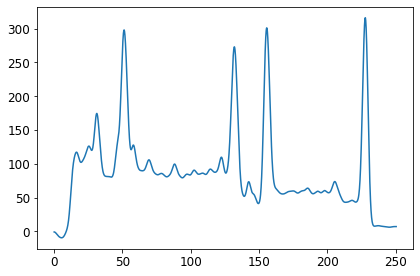

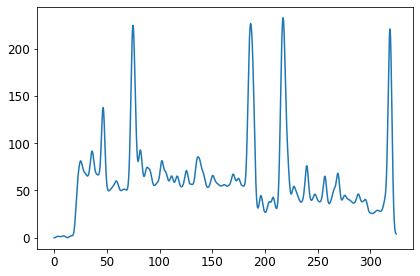

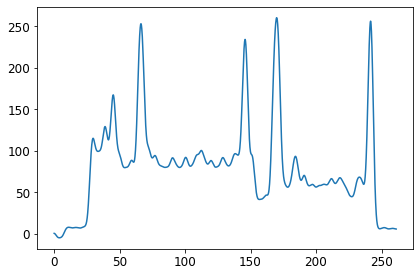

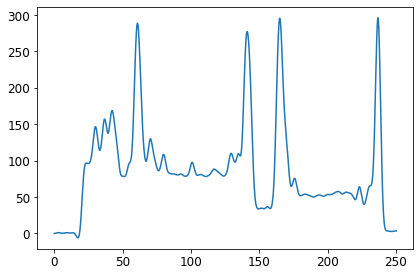

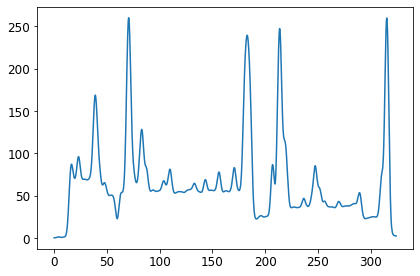

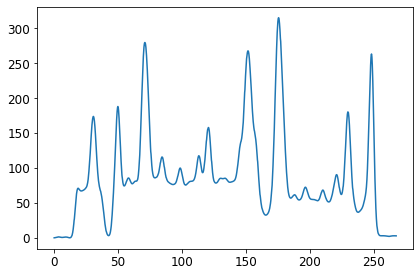

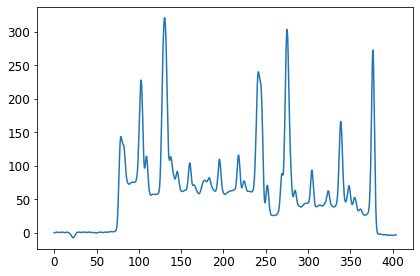

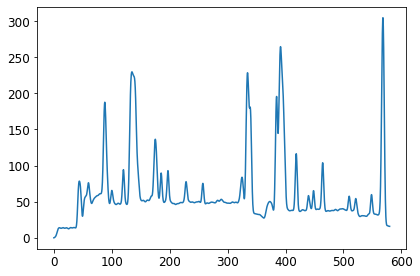

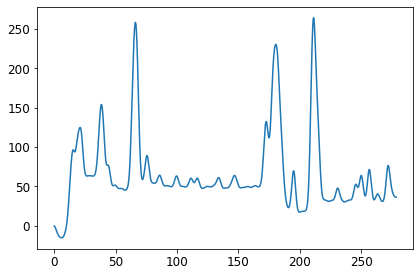

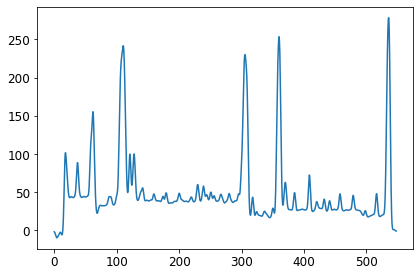

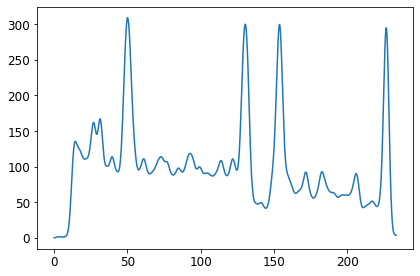

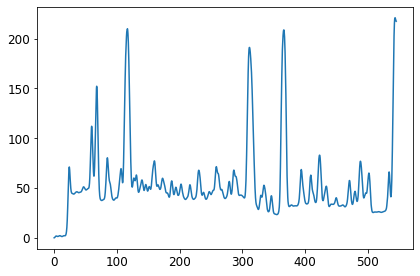

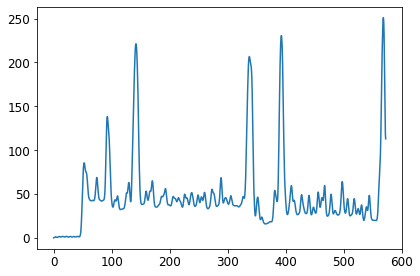

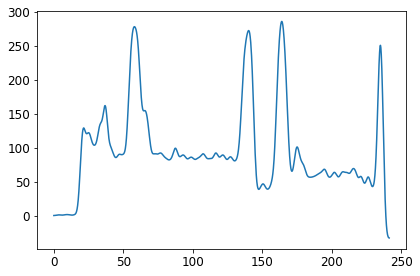

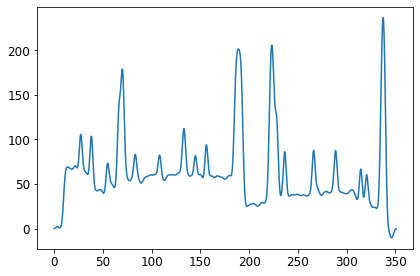

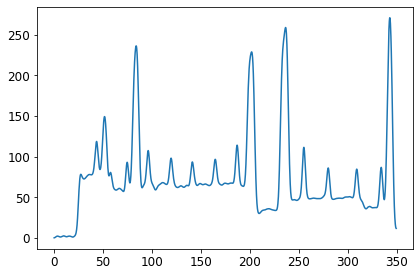

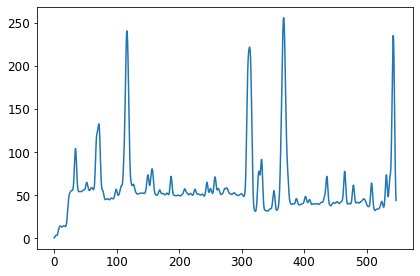

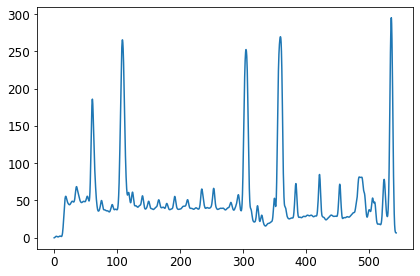

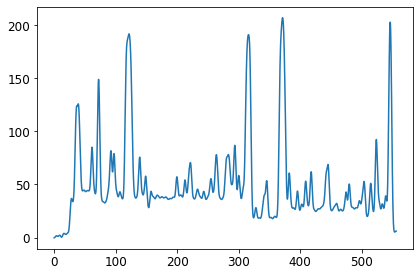

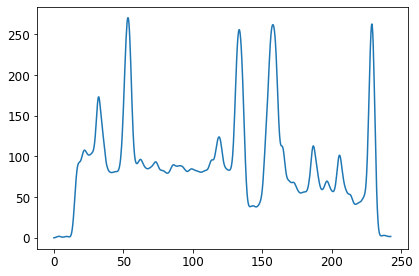

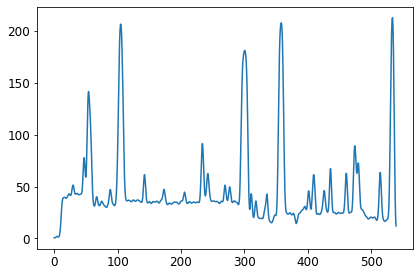

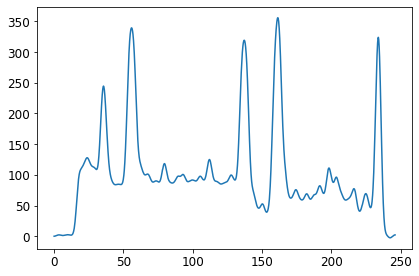

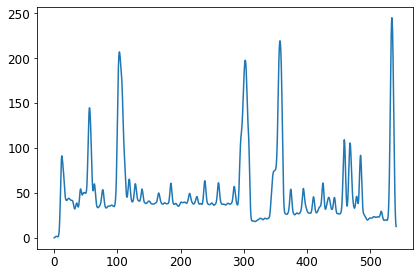

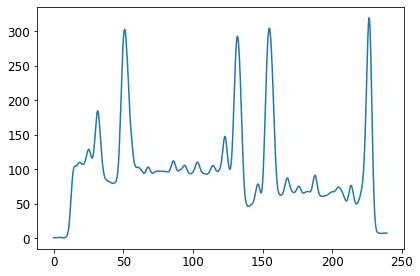

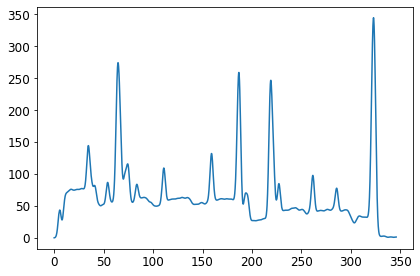

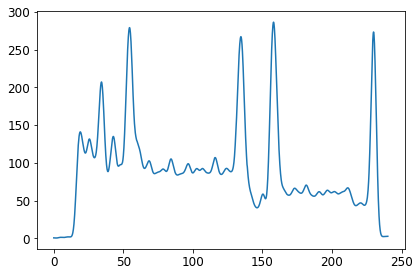

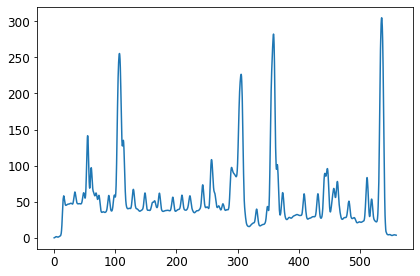

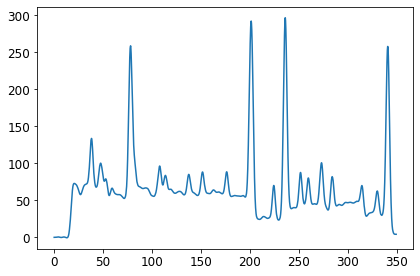

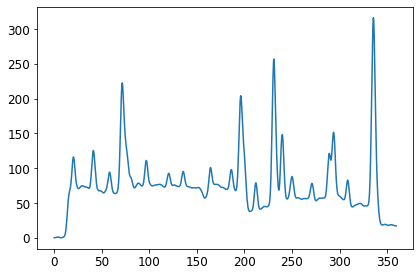

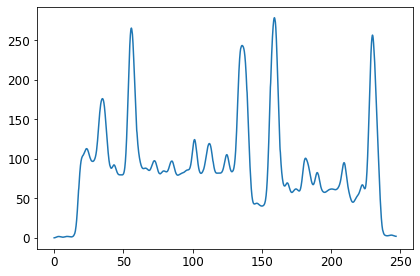

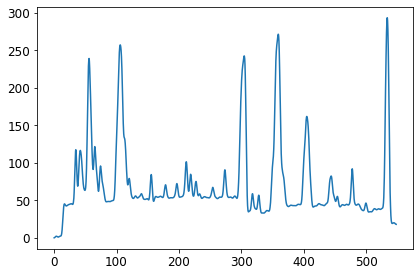

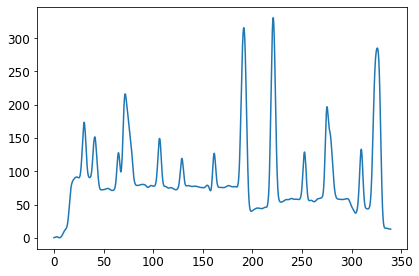

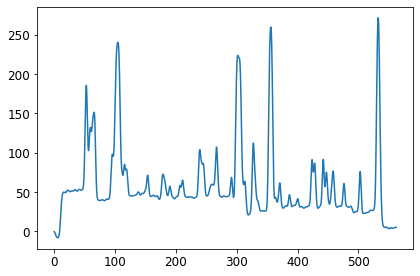

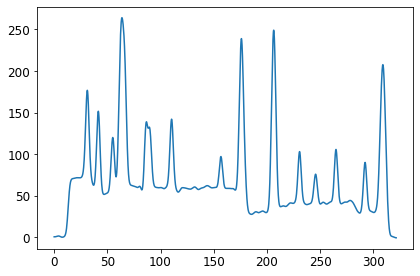

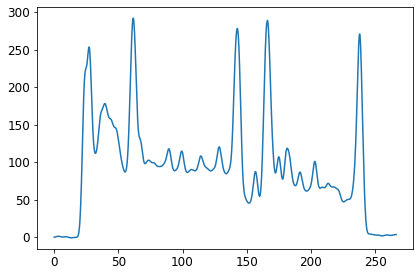

In [55]:
power_avg = []
for test in tests:
    df = data[data.test==test].copy()
    plt.plot(df.time, df.power_smooth)
    plt.show()
    power_avg.append(df.power_smooth.mean())


(array([5., 3., 5., 5., 3., 1., 1., 6., 3., 3.]),
 array([ 45.57806362,  51.37766971,  57.17727581,  62.9768819 ,
         68.776488  ,  74.57609409,  80.37570019,  86.17530628,
         91.97491237,  97.77451847, 103.57412456]),
 <BarContainer object of 10 artists>)

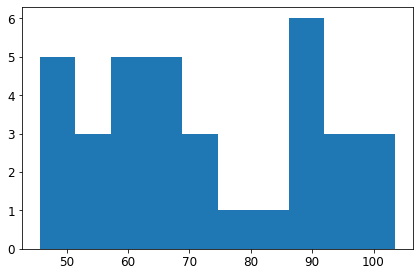

In [56]:
plt.hist(power_avg)

In [57]:
B.power_smooth.mean()

67.14096820824301

In [58]:
base = [(starship_a + starship_b)/2, (scout_a + scout_b)/2]
high = [starship_a, scout_a]
low = [starship_a, scout_b]

In [59]:
rho = 1.2
g = 9.81
Crr = 0.07 # https://www.school-for-champions.com/science/friction_rolling_coefficient.htm#.YrB9HHbMJaY
Z = 0.02
Cd = 2.1  # Rectangular box https://www.engineeringtoolbox.com/drag-coefficient-d_627.html
A = (0.33-0.13)*(0.67)  # m^2 approximately 

payload = 10 # kg
Wt = 50 + payload # kg
a = 0.4
nbw = 0.45
nbr = 0
Lh = 0

Wts = [50 + payload, 45 + payload, 23 + payload] 
vehicle = ["50 kg Husky", '45 kg (Amazon Scout)', '23 kg (Starship Robot)']
Crrs = [0.0, 0.1]
v = 1


husky_a = power_model(0.07, 60, g, 1, 0.45, Z, a)
husky_b = power_model(0.02, 60, g, 1, 0.8, Z, a)
husky_c = power_model((0.02+0.07)/2, 60, g, 1, (0.45+0.8)/2, Z, a)
print("Husky")
print(husky_a, husky_b, husky_c)

starship_a = power_model(0.07, 33, g, 1, 0.45, Z, a)
starship_b = power_model(0.02, 33, g, 1, 0.8, Z, a)
starship_c = power_model((0.02+0.07)/2, 33, g, 1, (0.45+0.8)/2, Z, a)
print("\nStarship")
print(starship_a, starship_b, starship_c)

scout_a = power_model(0.07, 55, g, 1, 0.45, Z, a)
scout_b = power_model(0.02, 55, g, 1, 0.80, Z, a)
scout_c = power_model((0.02+0.07)/2, 55, g, 1, (0.45+0.8)/2, Z, a)
print("\nScout")
print(scout_a, scout_b, scout_c)

hl_s1 = [(60+15)/2, 25.2, 0, 6, 4, 2, 0.13]
hl_s2 = [(60+15)/2, 25.2, 16, 6, 4, 2, 0.13]
hl_s3 = [(30+10)/2, 25.2, 0, 6, 4, 2, 0.13]


Husky
144.38666666666668 44.42999999999999 80.4144

Starship
79.41266666666667 24.436500000000002 44.227920000000005

Scout
132.35444444444448 40.727500000000006 73.7132


In [60]:
(0.02+0.07)/2

0.045000000000000005

In [61]:
(0.45+0.8)/2

0.625

In [62]:
motion_base = [scout_c, starship_c]
motion_best = [scout_b, starship_b]
motion_worst = [scout_a, starship_a]

df = pd.DataFrame({"Motion": motion_base, "Hotel load": [np.sum(hl_s2), np.sum(hl_s1)]}, index=['Amazon Scout', 'Starship'])

df["best"] = np.array(motion_best)+np.sum(hl_s3)-(30+10)/2+10
df['base'] = df.Motion + df['Hotel load']
df['worst'] = np.array(motion_worst) + np.array([np.sum(hl_s2),np.sum(hl_s1)])-(60+15)/2+15

df

,Motion,Hotel load,best,base,worst
Amazon Scout,73.71320,90.83,88.0575,164.54320,200.684444
Starship,44.22792,74.83,71.7665,119.05792,131.742667


In [63]:
[(df.base-df.best).values,(df.worst-df.base).values]

[array([76.4857 , 47.29142]), array([36.14124444, 12.68474667])]

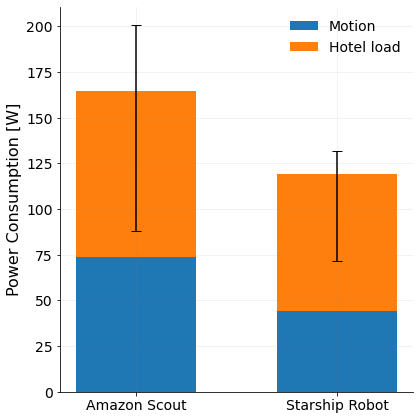

In [64]:

labels = ['Amazon Scout', 'Starship Robot']
width=0.6
errors = [(df.base-df.best).values,(df.worst-df.base).values]

fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(6)

#df.plot(kind="bar", stacked="True", figsize=(8,6))
ax.bar(labels, df["Motion"], width,label='Motion')
ax.bar(labels, df["Hotel load"], width, yerr=errors, bottom=df['Motion'], label='Hotel load', capsize =5)


sns.despine(top=True, right=True)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Power Consumption [W]", fontsize=16)
plt.legend(frameon=False, fontsize=14)
plt.grid(b=True, which='major', axis='both', color='gray', linewidth=1.0, alpha=0.1)
plt.savefig("total_power.png")

In [65]:
df

,Motion,Hotel load,best,base,worst
Amazon Scout,73.71320,90.83,88.0575,164.54320,200.684444
Starship,44.22792,74.83,71.7665,119.05792,131.742667


In [66]:
vc

,vehicle,e_base,e_low,e_high,ghg_base,ghg_high,ghg_low
0,Medium duty diesel truck,11.000000,8.800000,13.200000,931.590000,1086.140000,780.340000
1,Small diesel vans,4.900000,3.920000,5.880000,414.981000,483.826000,347.606000
2,Medium duty e-truck,3.800000,3.040000,4.560000,782.478685,1249.414925,445.992465
3,Small electric van,1.650000,1.320000,1.980000,343.460927,546.331405,197.240496
4,Electric cargo bicycle,0.100000,0.080000,0.120000,23.445557,33.781770,12.476957
5,Quad-copter drone,0.075000,0.070000,0.080000,17.534114,29.399622,9.499852
6,Amazon Scout,0.199979,0.126468,0.298595,42.967930,65.992503,22.397584
7,Starship Robot,0.144699,0.087223,0.214807,30.782645,47.529037,16.173017


In [67]:
vc.loc[6,['e_base', 'e_low','e_high']] = df.loc['Amazon Scout', ['base', 'best','worst']].values/3.6*0.0036
vc.loc[7,['e_base', 'e_low','e_high']] = df.loc['Starship', ['base', 'best','worst']].values/3.6*0.0036

vc


,vehicle,e_base,e_low,e_high,ghg_base,ghg_high,ghg_low
0,Medium duty diesel truck,11.000000,8.800000,13.200000,931.590000,1086.140000,780.340000
1,Small diesel vans,4.900000,3.920000,5.880000,414.981000,483.826000,347.606000
2,Medium duty e-truck,3.800000,3.040000,4.560000,782.478685,1249.414925,445.992465
3,Small electric van,1.650000,1.320000,1.980000,343.460927,546.331405,197.240496
4,Electric cargo bicycle,0.100000,0.080000,0.120000,23.445557,33.781770,12.476957
5,Quad-copter drone,0.075000,0.070000,0.080000,17.534114,29.399622,9.499852
6,Amazon Scout,0.164543,0.088057,0.200684,42.967930,65.992503,22.397584
7,Starship Robot,0.119058,0.071766,0.131743,30.782645,47.529037,16.173017


In [68]:
vc['pack_low'] = [1.5,1.5,1.5,1.5,0.25,0.125, 1, 1]
vc['pack_base'] = [2.1, 3.48, 2.1, 3.48, 1, 0.25, 1 ,1 ]
vc['pack_high'] = [5, 5, 5, 5, 3, 0.5, 1, 1]
vc

,vehicle,e_base,e_low,e_high,ghg_base,ghg_high,ghg_low,pack_low,pack_base,pack_high
0,Medium duty diesel truck,11.000000,8.800000,13.200000,931.590000,1086.140000,780.340000,1.500,2.10,5.0
1,Small diesel vans,4.900000,3.920000,5.880000,414.981000,483.826000,347.606000,1.500,3.48,5.0
2,Medium duty e-truck,3.800000,3.040000,4.560000,782.478685,1249.414925,445.992465,1.500,2.10,5.0
3,Small electric van,1.650000,1.320000,1.980000,343.460927,546.331405,197.240496,1.500,3.48,5.0
4,Electric cargo bicycle,0.100000,0.080000,0.120000,23.445557,33.781770,12.476957,0.250,1.00,3.0
5,Quad-copter drone,0.075000,0.070000,0.080000,17.534114,29.399622,9.499852,0.125,0.25,0.5
6,Amazon Scout,0.164543,0.088057,0.200684,42.967930,65.992503,22.397584,1.000,1.00,1.0
7,Starship Robot,0.119058,0.071766,0.131743,30.782645,47.529037,16.173017,1.000,1.00,1.0


0.5 0.176115 0.4013688888888889


C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/2574508370.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,5)


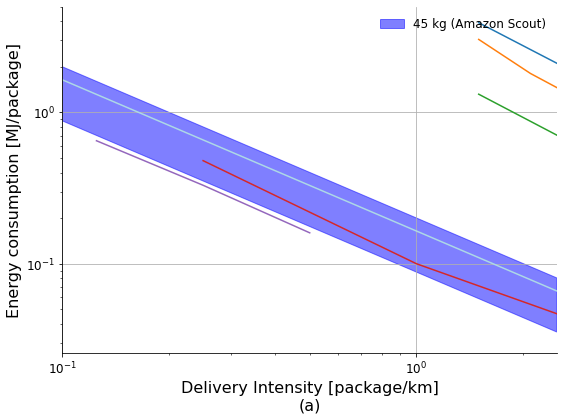

In [69]:
pack_km = np.arange(1/100, 1/0.4 , 0.02)

e_pack = []
e_pack_high = []
e_pack_low = []

plt.figure(figsize=(8, 6))
for i in pack_km:
    e_pack.append(vc.loc[6,'e_base']/i)
    e_pack_high.append(vc.loc[6,'e_high']/i)
    e_pack_low.append(vc.loc[6,'e_low']/i)

i = 0.5
print(i, vc.loc[6,'e_low']/i, vc.loc[6,'e_high']/i)


plt.fill_between(pack_km, y1=e_pack_high, y2=e_pack_low, alpha=0.5, color='blue', label='45 kg (Amazon Scout)')
plt.plot(pack_km, e_pack, color="lightblue")
#plt.plot(pack_km, e_pack, color='black')
for i in range(1,6):
    x = [vc.loc[i, 'pack_low'], vc.loc[i, 'pack_base'], vc.loc[i, 'pack_high']]
    y = [vc_pack.loc[i,'e_high'], vc_pack.loc[i,'e_base'], vc_pack.loc[i,'e_low']]
    plt.plot(x,y)
    plt.yscale("log")
    plt.xscale("log")
    #plt.fill_between(pack_km, y1=vc_pack.loc[i,'e_low'],y2= vc_pack.loc[i,'e_high'], alpha=0.5)
    #plt.text(1.8, vc_pack.loc[i,'e_base']+0.02, vc_pack.loc[i,'vehicle'])


plt.xlim(0.1,2.5)
plt.ylim(0,5)
plt.xlabel("Delivery Intensity [package/km]\n(a)", fontsize=16)
plt.ylabel("Energy consumption [MJ/package]", fontsize=16)
plt.grid(which="Major")
sns.despine(top=True, right=True)
plt.legend(frameon=False, loc="upper right")
plt.savefig("delivey_intensity_scout.tiff")
plt.show()


In [70]:

vc_df = pd.read_csv("vehicle_km_comparison.csv")

vc_df['pack_low'] = [1.5,1.5,1.5,1.5,0.25,0.125, 1, 1]
vc_df['pack_base'] = [2.1, 3.48, 2.1, 3.48, 1, 0.25, 1 ,1 ]
vc_df['pack_high'] = [5, 5, 5, 5, 3, 0.5, 1, 1]

In [71]:
vc = vc_df.copy()

0.5 0.252936316 0.597190082


C:\Users\thiag\AppData\Local\Temp/ipykernel_17740/2417716909.py:31: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,5)


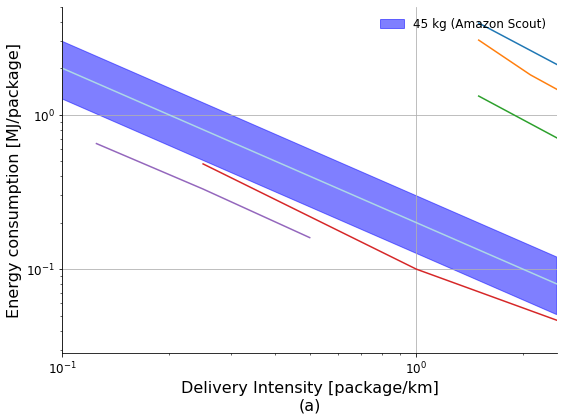

In [72]:
pack_km = np.arange(1/100, 1/0.4 , 0.02)

e_pack = []
e_pack_high = []
e_pack_low = []

plt.figure(figsize=(8, 6))
for i in pack_km:
    e_pack.append(vc.loc[6,'e_base']/i)
    e_pack_high.append(vc.loc[6,'e_high']/i)
    e_pack_low.append(vc.loc[6,'e_low']/i)

i = 0.5
print(i, vc.loc[6,'e_low']/i, vc.loc[6,'e_high']/i)


plt.fill_between(pack_km, y1=e_pack_high, y2=e_pack_low, alpha=0.5, color='blue', label='45 kg (Amazon Scout)')
plt.plot(pack_km, e_pack, color="lightblue")
#plt.plot(pack_km, e_pack, color='black')
for i in range(1,6):
    x = [vc.loc[i, 'pack_low'], vc.loc[i, 'pack_base'], vc.loc[i, 'pack_high']]
    y = [vc_pack.loc[i,'e_high'], vc_pack.loc[i,'e_base'], vc_pack.loc[i,'e_low']]
    plt.plot(x,y)
    plt.yscale("log")
    plt.xscale("log")
    #plt.fill_between(pack_km, y1=vc_pack.loc[i,'e_low'],y2= vc_pack.loc[i,'e_high'], alpha=0.5)
    #plt.text(1.8, vc_pack.loc[i,'e_base']+0.02, vc_pack.loc[i,'vehicle'])


plt.xlim(0.1,2.5)
plt.ylim(0,5)
plt.xlabel("Delivery Intensity [package/km]\n(a)", fontsize=16)
plt.ylabel("Energy consumption [MJ/package]", fontsize=16)
plt.grid(which="Major")
sns.despine(top=True, right=True)
plt.legend(frameon=False, loc="upper right")
plt.savefig("delivey_intensity_scout.tiff")
plt.show()